In [1]:
import pandas as pd
import numpy as np
import re
import os
import json


from plotting import create_df_for_forestplot, create_forestplot, save_pdf
from tables import create_supp_table

In [2]:
def get_most_deleterious_idx(ser):
    all_masks = set(ser.unique())
    most_del = "Missense_lenient"
    if "pLoF" in all_masks:
        most_del = "pLoF"
    elif "Missense_strict" in all_masks:
        most_del = "Missense_strict"
    most_del_idx = ser.loc[ser==most_del].index[0]
    return most_del_idx

In [3]:
# Obesity genes that were found in 
# 1. Rare variant burden association studies of BMI 
# 2. Must be in multiple cohorts 
# 3. Not sex specific or known ancestry specific 
# Note: Turcot genes are all driven by a single variant


kaisinger_genes = [
    "DIDO1", "PTPRG", "SLC12A5"
]
study_genes = set([
    "SLTM", "APBA1", "BLTP1", "PCSK1", "YLPM1", "MC4R", "BSN", "UBR2", "UBR3", "GIGYF1", "GRM7", "SLC5A3", "RIF1"
])

with open("../data/hgnc/hgnc_gene_map.json") as f:
    hgnc_dict = json.load(f)

kaisinger_genes = [hgnc_dict[g] for g in kaisinger_genes if hgnc_dict[g] not in study_genes]





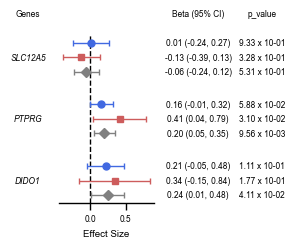

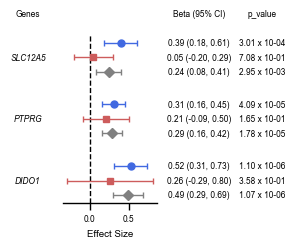

In [4]:
for sex in ["male", "female"]:
    meta_res_df = pd.read_csv(f"../data/meta/results/{sex}/ivw_fixed/bmi_rint_meta_results.tsv.gz", sep="\t")
    known_genes_df = meta_res_df.loc[meta_res_df.gene.isin(kaisinger_genes)]
    most_del_known_df = known_genes_df.loc[known_genes_df.groupby("gene")["gene_mask"].apply(get_most_deleterious_idx)].sort_values("beta").reset_index(drop=True)
    # Create forest plot
    long_plot_df = create_df_for_forestplot(most_del_known_df)
    fig = create_forestplot(
        long_plot_df, long_plot_df.gene.unique(), ["european", "non-european", "all"],
        labels_col="gene", categories_col="category", effect_sizes_col="beta", ci_low_col="ci_low", ci_high_col="ci_high",
        stats_cols=["Beta (95% CI)", "formatted_p_value"]
    )
    save_pdf(f"../data/known_genes/{sex}_forestplot.pdf", fig)
    # Create supp table
    anc_dir = f"../data/meta/processed/{sex}/"
    supp_table = create_supp_table(most_del_known_df, anc_dir, include_samples=True)
    supp_table.to_excel(f"../data/known_genes/sex_specific_known_{sex}.xlsx")


# Supplementary Table